In [1]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class RNNVAE(nn.Module):
    def __init__(self, embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(RNNVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    
    def forward(self, x):
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)

        _, hn = self.encoder(embedded_input)

        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        z = self.reparametrization(mu, logvar)

        z = self.fc_hidden(z)

        # prepare sos_token for the decoder
        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        sos_token = self.layer_norm(sos_token)

        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]

        reconstructed_sequence, _ = self.decoder(decoder_input, z)
        '''# reconstructing sequence through the decoder giving z as hidden state for each time step
        reconstructed_sequence = []
        for t in range(x.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,:t+1,:], z)
            reconstructed_sequence.append(outputs[:,-1,:].unsqueeze(1))

        # concatenating reconstructed words and push them into vocab_size dimensions
        reconstructed_sequence = torch.cat(reconstructed_sequence, dim=1)'''
        reconstructed_sequence = self.fc(reconstructed_sequence)
        
        return reconstructed_sequence, mu, logvar
    


    def reparametrization(self, mu, log_var):
        ''' Reparametrization trick
        
        Inputs
        -------
        mu : torch tensor
        log_var : torch tensor
            
        
        Returns
        -------
        mu + eps*std : torch tensor with the same shape as mu and log_var'''
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps*std


    def reconstruction(self, x, sample_type = 'multinomial'):
        ''' Reconstruction function for inference
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
            
        
        Returns
        -------
        outputs : torch tensor with shape [Batch_size, Sequence_length, Embedding_dim], the reconstructed sentence'''
        self.eval()
        with torch.no_grad():

            # embedding input and GRU encoder pass
            embedded_input = self.embedding(x)
            embedded_input = self.layer_norm(embedded_input)
            _, hn = self.encoder(embedded_input)
            
            # computing mu and log_var for style and content space
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)

            # concatenating style and content space
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(x.shape[1]):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
        
            
            
        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)
            
        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
            

        reconstructed_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(reconstructed_text)
    

    def sample(self, len_sample = 25, sample_type = 'multinomial'):
        z = torch.randn((self.num_layers, 1, self.latent_dim))

        self.eval()
        with torch.no_grad():
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(1,1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(len_sample):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
       

        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)

        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
        
        

        sampled_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(sampled_text)
    

    

    def number_parameters(self):

        model_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print('Total number of model parameters: ', model_params)

        return None

In [4]:
class GRUVAE(RNNVAE, nn.Module):
    def __init__(self, embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(GRUVAE, self).__init__(embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, num_layers, sos_token, vocab_size)

        self.embedding_dim = embedding_matrix.shape[1]
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

In [5]:
class LSTMVAE(nn.Module):
    def __init__(self, embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super().__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.sos_token = sos_token
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.LSTM(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.GRU(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)



    def forward(self, x):
        embedded_input = self.embedding(x)
        embedded_input = self.layer_norm(embedded_input)

        _, (hn, cn) = self.encoder(embedded_input)

        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        z = self.reparametrization(mu, logvar)

        z = self.fc_hidden(z)

        # prepare sos_token for the decoder
        sos_token = self.sos_token.repeat(x.size(0),1)
        sos_token = self.embedding(sos_token)
        sos_token = self.layer_norm(sos_token)

        decoder_input = torch.cat((sos_token, embedded_input), dim = 1)
        decoder_input = decoder_input[:,:-1,:]

        reconstructed_sequence, _ = self.decoder(decoder_input, z)
        '''# reconstructing sequence through the decoder giving z as hidden state for each time step
        reconstructed_sequence = []
        for t in range(x.shape[1]):
            outputs, _ = self.decoder(decoder_input[:,:t+1,:], z)
            reconstructed_sequence.append(outputs[:,-1,:].unsqueeze(1))

        # concatenating reconstructed words and push them into vocab_size dimensions
        reconstructed_sequence = torch.cat(reconstructed_sequence, dim=1)'''
        reconstructed_sequence = self.fc(reconstructed_sequence)
        
        return reconstructed_sequence, mu, logvar
    

    def reparametrization(self, mu, log_var):
        ''' Reparametrization trick
        
        Inputs
        -------
        mu : torch tensor
        log_var : torch tensor
            
        
        Returns
        -------
        mu + eps*std : torch tensor with the same shape as mu and log_var'''
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps*std
    
    

    def reconstruction(self, x, sample_type = 'multinomial'):
        ''' Reconstruction function for inference
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
            
        
        Returns
        -------
        outputs : torch tensor with shape [Batch_size, Sequence_length, Embedding_dim], the reconstructed sentence'''
        self.eval()
        with torch.no_grad():

            # embedding input and GRU encoder pass
            embedded_input = self.embedding(x)
            embedded_input = self.layer_norm(embedded_input)
            _, (hn, cn) = self.encoder(embedded_input)
            
            # computing mu and log_var for style and content space
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)

            # concatenating style and content space
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(x.shape[1]):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
        
            
            
        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)
            
        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
            

        reconstructed_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(reconstructed_text)
    

    def sample(self, len_sample = 25, sample_type = 'multinomial'):
        z = torch.randn((self.num_layers, 1, self.latent_dim))

        self.eval()
        with torch.no_grad():
            z = self.fc_hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(1,1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(len_sample):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                #next_token = torch.multinomial(F.softmax(outputs[:,-1,:], dim = -1), 1)
                next_token = self.embedding(next_token)
                next_token = self.layer_norm(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
                #output = torch.cat((output, next_token), dim=1)
       

        if sample_type == 'argmax':
            output = torch.argmax(F.softmax(outputs.mean(0), dim = -1), dim = -1)

        elif sample_type == 'multinomial':
            output = torch.multinomial(F.softmax(outputs.mean(0), dim = -1), 1)
        
        

        sampled_text = [self.idx2word[w.item()] for w in output]

        return ' '.join(sampled_text)
    

    

    def number_parameters(self):

        model_params = sum(p.numel() for p in self.parameters() if p.requires_grad)

        print('Total number of model parameters: ', model_params)

        return None

In [6]:
def divide_text(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words))]

    return output_text

In [7]:
def divide_text_equal_seq_length(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/6))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]

    return output_text

In [8]:
def custom_dataset(txt_file : str, sequence_length : int, embedding_dim : int, batch_size : int, training_fraction : float):
    ''' Function creating dataset
    
    Inputs
    ----------
    file1 : str, name of the file containing the text corpus
    sequence_length : int
    embedding_dim : int, number of dimension for the embedded words using Word2vec model
    batch_size : int
    training_fraction : float, fraction of training data
    
    
    Returns
    ----------
    dataloader_train : istance of torch.utils.data.Dataloader, training data
    dataloader_val : istance of torch.utils.data.Dataloader, validation data
    embedding_dim : int
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    word2vec : trained Word2vec model
    idx2word : dictionary from indices to words
    word2idx : dictionart from words to indices
    vocab_size : int, number of unique tokens
    style0_test : torch tensor containing every test data belonging to first style
    style1_test : torch tensor containing every test data belonging to second style
    style3_test : torch tensor containing every test data belonging to third style'''

    # reading the two corpus
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read()


    text = '<sos> ' + text
    # divide the whole text to feed the Word2vec model
    divided_text = divide_text(text, sequence_length)

    # training the Word2vec model with the whole corpus
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = sequence_length, min_count=1, workers=4, epochs = 30)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    # creating the embedding matrix from the trained Word2vec model
    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


    
    dataset = divide_text_equal_seq_length(text, sequence_length)
    dataset = torch.LongTensor([[word2idx[char] for char in dataset[i]] for i in range(len(dataset))])


    train_data = dataset[ : int(training_fraction * dataset.shape[0])]
    val_data = dataset[int(training_fraction * dataset.shape[0]) : ]

    dataset_train = TensorDataset(train_data)

    # Create a training DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)


    dataset_val = TensorDataset(val_data)

    # Create a validation DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size

In [9]:
def vae_loss(recon_x, x, mu, logvar, l_kl = 0.05, loss_fn = nn.CrossEntropyLoss()):
    ''' Function computing loss function for classification
    
    Inputs
    ---------
    pred_labels : 3D torch tensor with predicted labels with shape [1, Batch size, 3]
    labels : 2D torch tensor with ground truth labels with shape [Batch size, 3]
    
    Returns
    ---------
    L : float, loss value '''

    L = loss_fn(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))), x.view(-1))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return L + l_kl * KLD

# Sigmoid controlling l_kl:
* k = 0.183, t0 = 20
* k = 0.11, t0 = 30


k = - ln(32.33333)/(1-t0)

In [10]:
def sigmoid(x, k = 0.183, t0 = 20):
    
    return 1/(1 + np.exp(-k*(x-t0)))

In [11]:
def training(model, train_loader, val_loader, num_epochs, lr = 4e-4, title = 'Training'):
    ''' Training function
    
    Input
    --------
    model : istance of a CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier or TClassifier
    train_loader : istance of torch Dataloader with training data and labels
    val_loader : istance of torch Dataloader with validation data and labels
    num_epochs : int, number of epochs
    lr : float, learning rate for Adam optimizer
    title : str, Title of the matplot figure
    
    Returns
    --------
    train_losses : list with train loss values '''

    params = list(model.parameters())

    # Optimizer
    optimizer = torch.optim.Adam(params, lr = lr)

    
    train_losses = []
    val_losses = []
    

    l_kl = 0.05

    # For loop over epochs
    for epoch in tqdm(range(num_epochs)):
        #l_kl = sigmoid(epoch + 1)
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0


        # For loop for every batch
        for  i, (inputs) in enumerate(train_loader):
            inputs[0] = inputs[0].to(device)
            

            optimizer.zero_grad()
            

            # forward pass through classifier
            recon_x, mu, logvar = model(inputs[0])
    
            # comuting training loss
            loss = vae_loss(recon_x.to(device),
                            inputs[0].to(device),
                            mu.to(device),
                            logvar.to(device),
                            l_kl)
            
            loss.backward()
            train_loss += loss.item()


            optimizer.step()

            
            
        
        
        # Validation
        with torch.no_grad():
            for i, (inputs) in enumerate(val_loader):
                inputs[0] = inputs[0].to(device)
    

                # forward pass through classifier
                recon_x, mu, logvar = model(inputs[0])
                
                
                # comuting validation loss
                val_loss_tot = vae_loss(recon_x.to(device),
                                        inputs[0].to(device),
                                        mu.to(device),
                                        logvar.to(device),
                                        l_kl)
                
                val_loss += val_loss_tot.item()



            
        
        # Computing average training and validation loss
        average_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)

        

        # printing average training and validation losses
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
    

    # Plotting training and validation curve at the end of the for loop 
    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title + ' VAE Training')
    plt.show()


    return None

In [12]:
sequence_length = 30
batch_size = 128
embedding_dim = 300
hidden_dim = 128
latent_dim = 100

In [60]:
style_choice = 'Dante'  # Dante, Italian or Neapolitan

In [61]:
text_corpus = {'Dante' : 'divina_commedia.txt', 'Italian' : 'uno_nessuno_e_i_malavoglia.txt', 'Neapolitan' : 'lo_cunto_de_li_cunti.txt'}

train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size = custom_dataset(text_corpus[style_choice],
                                                                                                                    sequence_length,
                                                                                                                    embedding_dim,
                                                                                                                    batch_size,
                                                                                                                    0.9)

print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

total number of training samples:  18284
total number of validation samples:  2032
vocab size:  12762


In [62]:
sos_token = torch.full((1,),word2idx['<sos>'])
sos_token = sos_token.type(torch.LongTensor)

# RNN VAE Training

In [63]:
rnn_vae = RNNVAE(embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, 2, sos_token, vocab_size)
rnn_vae.number_parameters()

Total number of model parameters:  1861754


 14%|█▍        | 1/7 [01:01<06:09, 61.66s/it]

====> Epoch: 1 Average train loss: 0.2222, Average val loss: 0.0704


 29%|██▊       | 2/7 [02:04<05:12, 62.59s/it]

====> Epoch: 2 Average train loss: 0.0564, Average val loss: 0.0554


 43%|████▎     | 3/7 [03:13<04:21, 65.44s/it]

====> Epoch: 3 Average train loss: 0.0522, Average val loss: 0.0532


 57%|█████▋    | 4/7 [04:17<03:13, 64.63s/it]

====> Epoch: 4 Average train loss: 0.0498, Average val loss: 0.0519


 71%|███████▏  | 5/7 [05:19<02:07, 63.71s/it]

====> Epoch: 5 Average train loss: 0.0479, Average val loss: 0.0513


 86%|████████▌ | 6/7 [06:26<01:04, 64.98s/it]

====> Epoch: 6 Average train loss: 0.0464, Average val loss: 0.0508


100%|██████████| 7/7 [07:31<00:00, 64.53s/it]

====> Epoch: 7 Average train loss: 0.0450, Average val loss: 0.0506


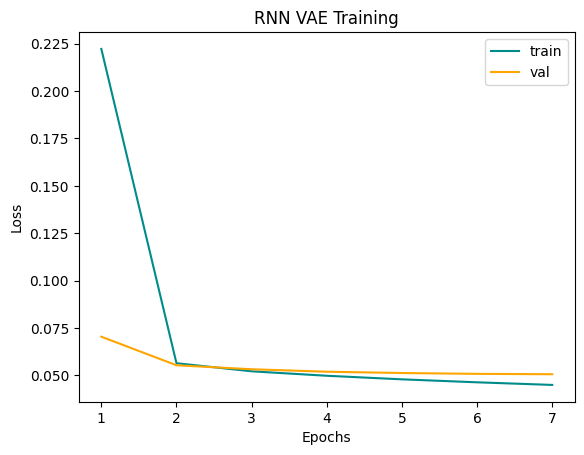

In [64]:
training(rnn_vae, train_loader, val_loader, 7, lr = 4e-4, title = 'RNN')

In [65]:
torch.save(rnn_vae.state_dict(), 'Dante_rnn_vae.pth')

In [17]:
for i ,(data) in enumerate(val_loader):
    if i == 0:
        sentence = data[0][0]
    else: 
        break

input_sentence = [idx2word[sentence[i].item()] for i in range(sentence.shape[0])]

sentence = sentence.view(1,sentence.shape[0])


reconstructed_sequence = rnn_vae.reconstruction(sentence, 'argmax')

reconstructed_sequence2 = rnn_vae.reconstruction(sentence)
    


print("Input sequence: \n", ' '.join(input_sentence))
print("\nReconstructed sequence ARGMAX: \n", reconstructed_sequence)
print("\nReconstructed sequence MULTINOMIAL: \n", reconstructed_sequence2)

Input sequence: 
 malavoglia per quella casa del nespolo che nessuno la voleva come se fosse scomunicata e gli era rimasta sulla pancia sicchè appena seppe che era tornato in paese alfio mosca

Reconstructed sequence ARGMAX: 
 e non si vedeva più e non si vedeva più e non si vedeva più e non si vedeva più e non si vedeva più e non si vedeva più

Reconstructed sequence MULTINOMIAL: 
 la colui vi poteva curato ma tutta potè legavano più nel per pretenderai avevano la a così potendo specchio così le scappò nobiltà dimostrato più estranei da mi tappò sapere


In [47]:
for i ,(data) in enumerate(train_loader):
    if i == 0:
        sentence = data[0][0]
    else: 
        break

input_sentence = [idx2word[sentence[i].item()] for i in range(sentence.shape[0])]

sentence = sentence.view(1,sentence.shape[0])

with torch.no_grad():
    reconstructed_sequence, _, _ = rnn_vae.forward(sentence)
    


indices = torch.argmax(reconstructed_sequence, dim=-1).squeeze(0)
indices2 = torch.multinomial(F.softmax(reconstructed_sequence.squeeze(0),dim=-1), 1)


reconstructed_sequence = []
for i in range(sentence.shape[1]):
    reconstructed_sequence.append(idx2word[indices2[i].item()])



print("Input sequence: \n", ' '.join(input_sentence))
print("\nReconstructed sequence 2: \n", ' '.join(reconstructed_sequence))

Input sequence: 
 visto vardiello sta mala desgrazia pensaje de remmediare a lo danno e fatto de la necessetà vertute azzò non se refredassero l ova sbracatose subeto se sedette ncoppa a lo

Reconstructed sequence 2: 
 nsomma de co sommiero pappamosche sentenno vui lo de jeppone gliottere li chisto a la notte giovane lo so vuoje la ceccone uerco e forca ncoppa ciance a sapere cadere


In [66]:
rnn_vae.sample(40)

'li non dì non non li carreggiar a sè mi l si per io io sì guerir travagliava tacque le fuor fatti me piene travasa e la e lui fassi tolse e più m a reggimenti fè qui qual v'

# GRU VAE Training

In [50]:
gru_vae = GRUVAE(embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, 2, sos_token, vocab_size)
gru_vae.number_parameters()

Total number of model parameters:  1607968


In [81]:
gru_vae.load_state_dict(torch.load('dante_gru_vae.pth'))

<ipython-input-81-9726af4abcc1>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  gru_vae.load_state_dict(torch.load('dante_gru_vae.pth'))


<All keys matched successfully>

 12%|█▎        | 1/8 [00:24<02:52, 24.70s/it]

====> Epoch: 1 Average train loss: 0.1430, Average val loss: 0.0736


 25%|██▌       | 2/8 [00:50<02:31, 25.23s/it]

====> Epoch: 2 Average train loss: 0.0594, Average val loss: 0.0585


 38%|███▊      | 3/8 [01:16<02:08, 25.66s/it]

====> Epoch: 3 Average train loss: 0.0538, Average val loss: 0.0576


 50%|█████     | 4/8 [01:42<01:43, 26.00s/it]

====> Epoch: 4 Average train loss: 0.0529, Average val loss: 0.0572


 62%|██████▎   | 5/8 [02:09<01:18, 26.13s/it]

====> Epoch: 5 Average train loss: 0.0521, Average val loss: 0.0567


 75%|███████▌  | 6/8 [02:35<00:52, 26.29s/it]

====> Epoch: 6 Average train loss: 0.0513, Average val loss: 0.0559


 88%|████████▊ | 7/8 [03:03<00:26, 26.54s/it]

====> Epoch: 7 Average train loss: 0.0501, Average val loss: 0.0547


100%|██████████| 8/8 [03:30<00:00, 26.29s/it]

====> Epoch: 8 Average train loss: 0.0487, Average val loss: 0.0535


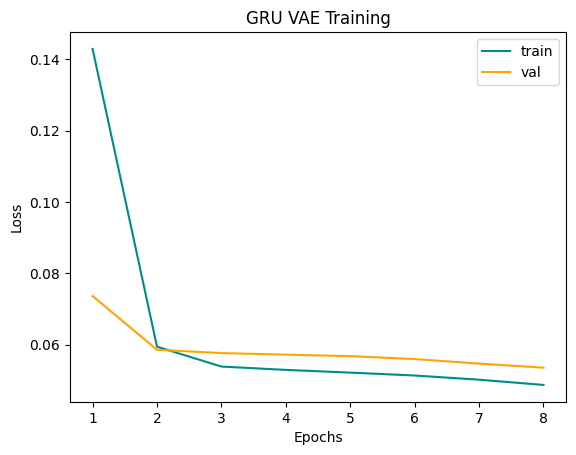

In [51]:
training(gru_vae, train_loader, val_loader, 8, lr = 4e-4, title = 'GRU')

In [52]:
torch.save(gru_vae.state_dict(), 'Neapolitan_gru_vae.pth')

# GRU VAE Inference

In [53]:
gru_vae.sample(40)

'patreto cielo la canneloro la respose m de a tresca assaporato se le milo e la figlio e correnno ntese jettava aisato munno autro se casca da la mogliere de porziella munno jodizio la prencepe schiaffa mula sole e la'

# LSTM VAE Training

In [54]:
lstm_vae = LSTMVAE(embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, 2, sos_token, vocab_size)
lstm_vae.number_parameters()

Total number of model parameters:  1696032


 10%|█         | 1/10 [00:26<04:02, 26.97s/it]

====> Epoch: 1 Average train loss: 0.0767, Average val loss: 0.0584


 20%|██        | 2/10 [00:52<03:28, 26.02s/it]

====> Epoch: 2 Average train loss: 0.0543, Average val loss: 0.0572


 30%|███       | 3/10 [01:18<03:01, 25.90s/it]

====> Epoch: 3 Average train loss: 0.0531, Average val loss: 0.0571


 40%|████      | 4/10 [01:44<02:35, 25.92s/it]

====> Epoch: 4 Average train loss: 0.0526, Average val loss: 0.0571


 50%|█████     | 5/10 [02:09<02:09, 25.81s/it]

====> Epoch: 5 Average train loss: 0.0522, Average val loss: 0.0569


 60%|██████    | 6/10 [02:36<01:44, 26.11s/it]

====> Epoch: 6 Average train loss: 0.0517, Average val loss: 0.0565


 70%|███████   | 7/10 [03:02<01:18, 26.09s/it]

====> Epoch: 7 Average train loss: 0.0509, Average val loss: 0.0555


 80%|████████  | 8/10 [03:28<00:52, 26.03s/it]

====> Epoch: 8 Average train loss: 0.0496, Average val loss: 0.0544


 90%|█████████ | 9/10 [03:54<00:25, 25.96s/it]

====> Epoch: 9 Average train loss: 0.0482, Average val loss: 0.0535


100%|██████████| 10/10 [04:20<00:00, 26.05s/it]

====> Epoch: 10 Average train loss: 0.0469, Average val loss: 0.0528


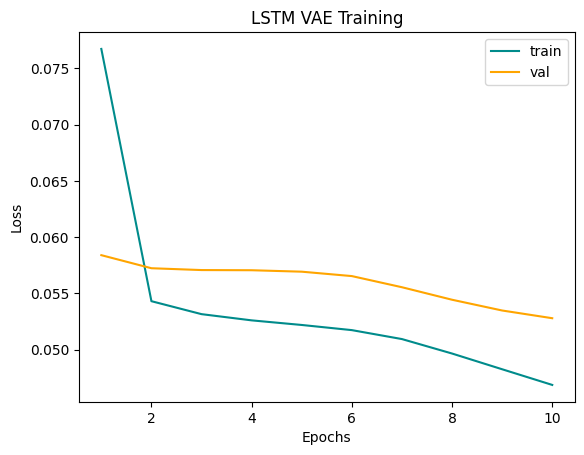

In [55]:
training(lstm_vae, train_loader, val_loader, 10, lr = 4e-4, title = 'LSTM')

In [58]:
torch.save(lstm_vae.state_dict(), 'Neapolitan_lstm_vae.pth')

In [28]:
lstm_vae.load_state_dict(torch.load('Italian_lstm_vae.pth'))

<ipython-input-28-1195fbd11903>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lstm_vae.load_state_dict(torch.load('Italian_lstm_vae.pth'))


FileNotFoundError: [Errno 2] No such file or directory: 'Italian_lstm_vae.pth'

In [59]:
lstm_vae.sample(40)

'tirare cardascio mille che nfroata disse non luna utemamente la piso penziero dui moschejanno scumpela coda canneloro ncriare core razza nante canna le aucielle bona piede cosa responnenno preganno core che parere volessono li mogliere berzagliare l quale liberarlo chi'